# The following notebook demonstrates the stochastic IMF algorithm implemented in the ChaNGa simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.gridspec as gridspec
import scipy.stats as ss

%matplotlib notebook

The Kroupa 2001 IMF class, used to calculate the expected number and mass of stars in a population

In [2]:
class kroupa01(ss.rv_continuous):
    def _pdf(self,m):
        if m<=0.5:
            return 0.252935*m**(-1.3)
        else:
            return 0.126467*m**(-2.3)

The inverse CDF, for drawing stars from the IMF

In [3]:
def kroupa_icdf(x):
    if x<0.760707:
        return ((1.798701-x)/0.843113)**-(1/0.3)
    else:
        return ((1.000244-x)/0.097282)**-(1/1.3)

The stop-nearest algorithm for generating a stellar population stochastically

In [4]:
def stop_nearest(popsize):
    current_mtot = 0.0
    stars = []
    while True:
            new_star = kroupa_icdf(np.random.random())
            if (current_mtot + new_star) < popsize:
                stars.append(new_star)
            elif abs(popsize - (current_mtot + new_star)) < abs(popsize - current_mtot):
                    stars.append(new_star)
                    break
            else:
                break
            current_mtot += new_star
    return np.array(stars)

Calculating the normalization for the reapproximated low-mass portion of the realized stellar population

In [5]:
def norm_calc(k01, stars, cutoff, popsize):
    high_mass_actual = stars[stars>=cutoff].sum()
    expect_low = k01.expect(ub=cutoff)/k01.expect()
    norm = (popsize-high_mass_actual)/expect_low

    return norm

A function to bin the IMF for the continuous portion, and return the discrete stars for the discrete portion

In [6]:
def half_stoch(stars, cutoff):
    counts, bin_edges = np.histogram(stars[stars<cutoff], bins=np.logspace(np.log10(0.08), np.log10(cutoff), len(stars)/20))
    counts = counts/np.diff(bin_edges)
    return counts, bin_edges, stars[stars>=cutoff]

### Set your parameters here

popsize - the mass (in solar masses) of the stellar population

cutoff - the dividing mass between continuously and discretely tracked stars within the population

In [7]:
popsize = 300.0
cutoff = 8.0

Setting up an initial realization of the stellar population

In [8]:
k01 = kroupa01(a=0.08, b=100.0)

stars = stop_nearest(popsize)
x = np.linspace(1, len(stars), len(stars))
y = np.cumsum(stars)
colors = np.ma.masked_where(stars>=cutoff, y)

counts, bins, discretes = half_stoch(stars, cutoff)

Creating the figure, initial plots, and other figure elements (slider and button)

<IPython.core.display.Javascript object>


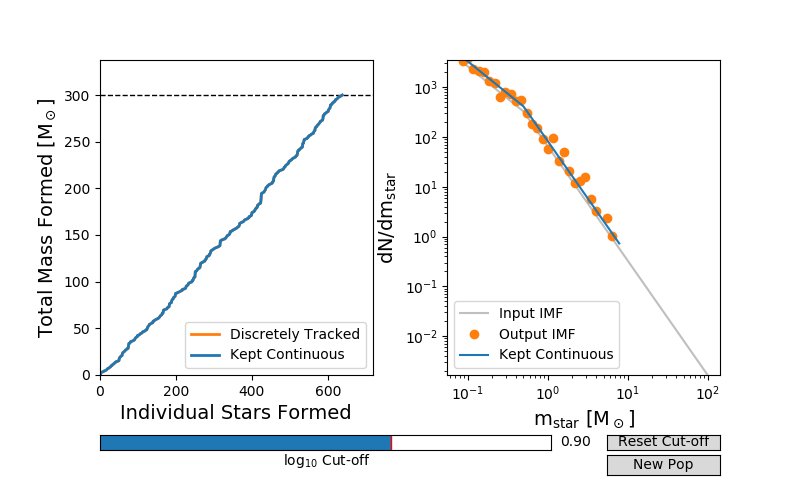

0

In [9]:
fig = plt.figure()
gs1 = gridspec.GridSpec(1, 2)
gs2 = gridspec.GridSpec(1, 2, width_ratios=(8, 2))
gs3 = gridspec.GridSpec(1, 2, width_ratios=(8, 2))
gs1.update(bottom = 0.25, wspace=0.275)
gs2.update(top = 0.13, bottom = 0.1)
gs3.update(top = .09, bottom = .05)
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs2[0])
ax4 = plt.subplot(gs2[1])
ax5 = plt.subplot(gs3[1])

fig.set_size_inches((8, 5))
ax1.set_xlim([0, len(stars)*1.125])
ax1.set_ylim([0, popsize*1.125])
ax1.axhline(popsize, linestyle='--', color='black', lw=1)
line1, = ax1.plot(x, y, lw=2, label='Discretely Tracked', color='C1')
line2, = ax1.plot(x, colors, lw=2, label='Kept Continuous', color='C0')
ax1.set_xlabel('Individual Stars Formed', fontsize=14)
ax1.set_ylabel('Total Mass Formed [M$_\odot$]', fontsize=14)
ax1.legend(loc='lower right')


masses = np.logspace(np.log10(0.0801), np.log10(100.0), 200)
default_imf = np.array([k01.pdf(mass) for mass in masses])*popsize/k01.expect()
norm = norm_calc(k01, stars, cutoff, popsize)

ax2.plot(masses, default_imf, color='grey', alpha=0.5, label='Input IMF')
scat1, = ax2.plot(0.5*(bins[:-1]+bins[1:]), counts, 'o', color='C1', label='Output IMF')
ax2.set_ylim(default_imf.min(), default_imf.max())
xverts, yverts = np.meshgrid(discretes, (default_imf.min(), default_imf.max()))
vertlines = ax2.plot(xverts, yverts, ls='--', color='C1')
line3, = ax2.plot(masses[masses<cutoff], np.array([k01.pdf(mass) for mass in masses[masses<cutoff]])*norm/k01.expect(), label='Kept Continuous')
ax2.loglog([], [])
ax2.set_xlabel('m$_\mathrm{star}$ [M$_\odot$]', fontsize=14)
ax2.set_ylabel('dN/dm$_\mathrm{star}$', fontsize=14)
ax2.legend(loc='lower left')


scut = Slider(ax3, 'log$_{10}$ Cut-off', np.log10(0.08), np.log10(100.0), valinit=np.log10(cutoff))
scut.label.set_position((0.6, -0.75))

reset_button = Button(ax4, 'Reset Cut-off')

new_button = Button(ax5, 'New Pop')

def update(val):
    cut = scut.val
    colors = np.ma.masked_where(stars>=10.0**cut, y)
    counts, bins, discretes = half_stoch(stars, 10.0**cut)
    norm = norm_calc(k01, stars, 10.0**cut, popsize)
    xverts, yverts = np.meshgrid(discretes, (default_imf.min(), default_imf.max()))
    scat1.set_data(0.5*(bins[:-1]+bins[1:]), counts)
    line2.set_data(x, colors)
    line3.set_data(masses[masses<10.0**cut], np.array([k01.pdf(mass) for mass in masses[masses<10.0**cut]])*norm/k01.expect())
    global vertlines
    for lin in vertlines:
        lin.remove()
    vertlines = ax2.plot(xverts, yverts, ls='--', color='C1')
            
            

def reset(event):
    scut.reset()
    
def new_pop(event):
    global stars
    global x
    global y
    global colors
    global counts, bins, discretes
    stars = stop_nearest(popsize)
    x = np.linspace(1, len(stars), len(stars))
    y = np.cumsum(stars)
    colors = np.ma.masked_where(stars>=cutoff, y)

    counts, bins, discretes = half_stoch(stars, cutoff)
    update(cutoff)
    line1.set_data(x, y)
    ax1.set_xlim((0, len(stars)*1.125))

scut.on_changed(update)
reset_button.on_clicked(reset)
new_button.on_clicked(new_pop)